# Tuturial on deploying neural networks for in-situ inference on frame grabber FPGAs in high-speed imaging.

Written by: Ryan Forelli

Last Modified: 11/26/2023

## Introduction

Many scientific domains utilize high-speed imaging to aid in experimentation and discovery. From analyzing fusion magneto hydrodynamics to crystal structure detection in transmission electron microscopy, there is need for in-situ fast inference in these experiements which operate in the kHz to MHz range. Typically, a dedicated PCIe frame grabber device is paired with a high-speed camera to handle high the throughput, and a protocol such as CoaxPress is used to trasmit the raw camera data between the systems. Many frame grabbers implement this protocol as well additional pixel preprocessing stages on an FPGA device. Some manufacturers such as Euresys have enabled easy access to their FPGA firmware reference design. This refernce design, aptly named CustomLogic, allows the user to implement custom image processing functions on the available portion of their frame grabber FPGAs. Moreover, open-source codesign workflows like hls4ml enables easy translation and deployment of neural networks to FPGA devices, and have demonstrated latencies on the order of nanoseconds to microseconds with successful applications using standard FPGA accelerators to many domains including particle physics and material science. Here, we demonstrate the process of melding the CustomLogic and hls4ml workflows to yield a frame grabber neural network implementation, complete with C/RTL simulation tools and built-in HDL to enable easy inference latency benchmarking. 

Table of Contents
- 

### Software Requirements
- Vivado 2018.3
- hls4ml 0.7.0 or newer

### Hardware Requirements
The included firmware reference designs only support the following Euresys cameras
- 3603 Coaxlink **Quad CXP-12**
- 3602 Coaxlink **Octo**

### Neural Network requirements
- All architectures supported by hls4ml are supported by this reference design.
- Neural network output must have a total packed bitwidth of.
    - 256 bits or less for the Quad CXP-12
    - 128 bits or less for the Octo

### Supported pixel formats
- The frame grabber reference design suports the following pixel formats. Be sure your model is trained on data captured in one of these formats on the camera you intend to deploy to for best results. 
  - Mono 8-bit
  - Mono 12-bit
  - Mono 16-bit

### Camera acquisition requirements
It is _highly_ advised that you configure your camera acquisition to an image width which is a multiple of the values defined below. These values are set based on the desired pixel depth and firmware stream depth (256 bits on Quad CXP-12, 128 bits on Octo).
- Quad CXP-12 (8-bit). Width must be multiple of **32**
- Quad CXP-12 (12-bit). Width must be multiple of **16**
- Quad CXP-12 (16-bit). Width must be multiple of **16**
- Octo (8-bit). Width must be multiple of **16**
- Octo (12-bit). Width must be multiple of **8**
- Octo (16-bit). Width must be multiple of **8**

### Model results
There are two methods to retreive the neural network predictions from the frame grabber FPGA. This guide will utilize method 2. 
1. Embed predictions in image. Using this method, model predictions are packed into a single n-bit word, inserted into the final packet of the image, and returned to host along with the captured image. As demonstrated later, a simple python script can extract these predictions. The limitation of this method is that the acquisition y or x width must be oversized to accomodate the model predications without deleting a portion of the model input. Extracting and parsing model results by this method is far more scalable, but less suited to real-time control applications than method 2.
2. Write predictions serially over frame grabber TTL/RS422 IO. The Octo and Quad CXP frame grabbers feature [two 1MHz TTL general purpose IO](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/meca/connectors/inst300-int-io1.htm?tocpath=Using%20Coaxlink%7CHardware%20Manual%7CMechanical%20Specification%7CConnectors%7C_____15) (or ten [10MHz RS422 IO](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/elec/differential-io.htm) by way of [this](https://www.euresys.com/en/Products/Accessory/HD26F-I-O-Extension-Module-TTL-CMOS5V-RS422) extension module). This method is more suited to real-time applications where the frame grabber must communicate with a downstream system. Example code for outputting model results serially is included in 04_ref_design/result_writeout.v. This verilog can be customized to output your models predictions. Note that the module instantiation is currently commented out in the top-level HDL file (CustomLogic.vhd).
3. Coming soon...

### Download project files

First lets download the template reference design which we will use for this tutorial, as well as the pattern test projects which are described below.

In [48]:
import gdown
gdown.download("https://drive.google.com/uc?id=1BCu_GSPILykcaUJcW-ZKq36nxwrAq-es&export=download")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1BCu_GSPILykcaUJcW-ZKq36nxwrAq-es&export=download
From (redirected): https://drive.google.com/uc?id=1BCu_GSPILykcaUJcW-ZKq36nxwrAq-es&export=download&confirm=t&uuid=3e7124b4-a07f-4fe7-9a26-f70aae0eab2e
To: /home/rforelli/hls4ml-frame-grabbers/hls4ml-frame-grabbers.tar
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.69G/1.69G [00:15<00:00, 106MB/s]


'hls4ml-frame-grabbers.tar'

In [ ]:
!tar -xvf hls4ml-frame-grabbers.tar
!rm -rf *tar

### Before you begin!
Before we begin merging your neural network with the frame grabber reference design. We must determine the order of the CoaxPress output to the frame grabber, as this determines the pixel input order to your model. For example, the Phantom S710, which this tutorial targets, outputs a stream of data from the camera sensor which is in unnaturally ordered (see image stitching process in the [S710 manual](https://www.phantomhighspeed.com/-/media/project/ameteksxa/visionresearch/documents/datasheets/web/wdss710.pdf?download=1)). Normally, the frame grabber reorders the image data stream to represent the natural pixel order of the image. However, this processing block sits **after** our neural network custom logic in the functional diagram (see DMA block [here](https://documentation.euresys.com/Products/COAXLINK/COAXLINK_16_0/en-us/Content/11_Pdf/D209ET-Coaxlink_CustomLogic_User_Guide-eGrabber-16.0.2.2128.pdf#page=7)). Therefore, we must perform this "stripe reordering" operation manually.

First we must determine what the order of the raw CoaxPress image data. This information can sometimes be found in your cameras technical manual. However, in case it is not, a dedicated reference design is included which will allow you to empirically determine this order. The reference design hardcodes a gradient of pixel values from 0 to 2^n where n is your selected pixel depth. For example, the following gradient was harcoded to the custom logic output stream. (excluding sequence numbers)
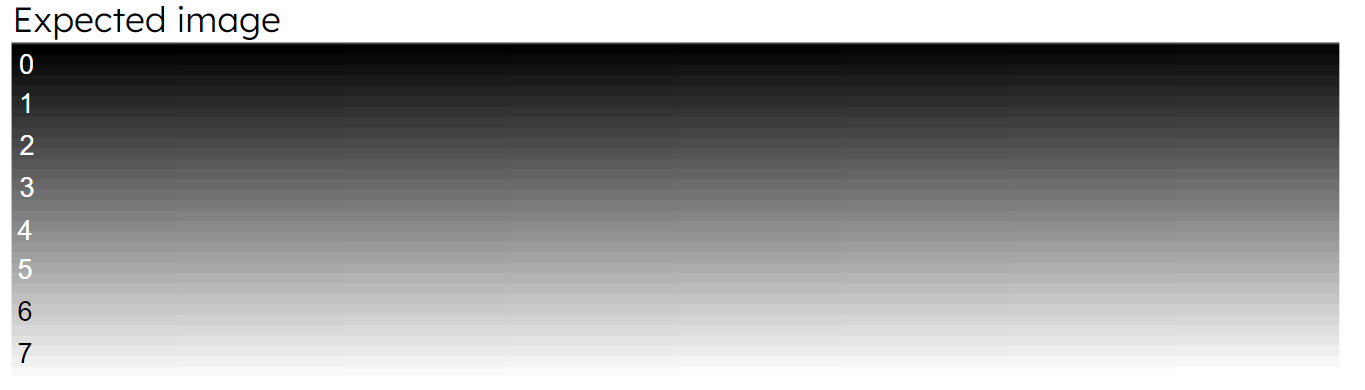

However, at the host, the following image was received (excluding sequence numbers)
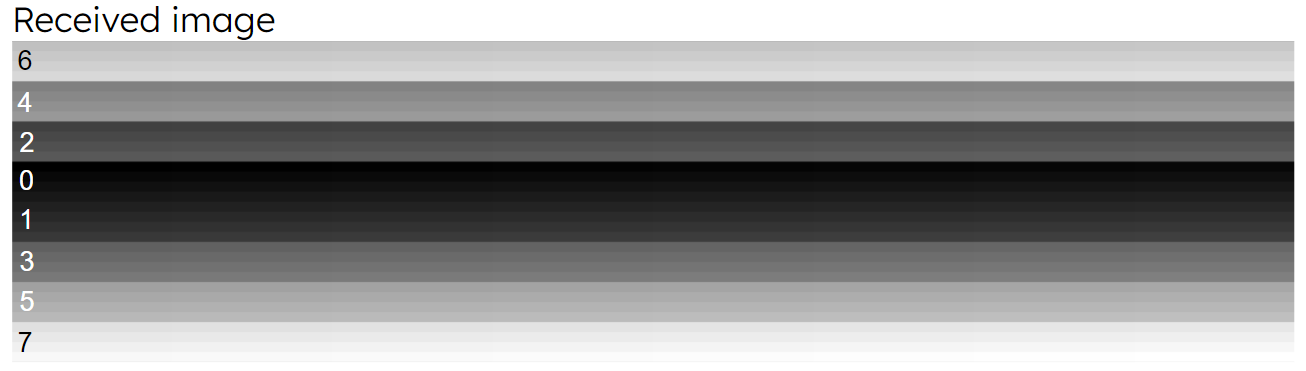

As you can see image is split into 8 stripes and reorganized from the order [0,1,2,3,4,5,6,7] to the order [6,4,2,0,1,3,5,7]. Thus, we must perform the same operation in our firmware. This process is the most difficult of the work to come. First select the appropriate reference design from the list below. All designs are located in ./pattern_tests. The bit stream correspond to each version is in 06_release. Currently, these designs are configured to output a gradient with 128 at each pixel value. If it is difficult to interpret the stripe pattern of your camera at your desired resolution, try increasing or decresing the GRAD_NUM value in 05_ref_design_hls/CustomLogic.h. Note that depending on your desired image dimensions, the gradient may wrap around at some point in the image. Take note of the order of your stripes for later. Ours was [6,4,2,0,1,3,5,7].


## Neural Network Integration

Note that you must have a fully compiled (not synthesized) HLS model, generated by hls4ml, to proceed to the next steps. For this tutorial, we will using the 8-bit depth reference design, targeting the Quad CXP-12, so we will be using the reference design template named "XXXX".

If you do not, you can follow along below to compile the MNIST example model from hls4ml's example-models repository. First lets just import a few packages and define some functions we will need later.

### Imports

In [1]:
import hls4ml
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import qkeras
import numpy as np
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import numpy as np

2023-11-27 17:22:33.146273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 17:22:33.186437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 17:22:33.186466: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 17:22:33.186493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 17:22:33.195120: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 17:22:33.195722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/rforelli/miniforge3/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


### Codes

In [2]:
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))  

In [3]:
def pad_images(images, pad_value=0, start_x=0, start_y=0, target_width=128, target_height=32):
    num_images, img_height, img_width = images.shape

    # Create an array to hold the padded images
    padded_images = np.full((num_images, target_height, target_width), pad_value, dtype=images.dtype)

    # Iterate through each image and place it within the padded array
    for i in range(num_images):
        # Calculate the end positions
        end_x = min(start_x + img_width, target_width)
        end_y = min(start_y + img_height, target_height)

        # Place the image within the padded array
        padded_images[i, start_y:end_y, start_x:end_x] = images[i, :end_y - start_y, :end_x - start_x]

    return padded_images

## Import pretrained/quantized model

As mentioned above, for this demonstration we will implement the pretrained quantized MNIST CNN example available from the hls4ml package. See [here](https://github.com/fastmachinelearning/hls4ml-tutorial) for tutorials on how to perform quantization aware training and how to convert your CNN to an HLS model using HLS4ML. The example model here already has a defined hls4ml configuration dictionary.

Take note of the output bitwidth of this model. It looks like this MNIST model output contains 16 bit values. Note that the specified FPGA part does not matter in this case.

In [4]:
config = hls4ml.utils.fetch_example_model('qkeras_mnist_cnn.json') # Import example CNN
print_dict(config)

Backend:             Vivado
ClockPeriod:         5
HLSConfig
  LayerName
    input_1
      Precision
        result:      ap_fixed<16,6>
      Trace:         True
    max_pooling2d
      Precision:     ap_fixed<16,6>
      Trace:         True
    max_pooling2d_1
      Precision:     ap_fixed<16,6>
      Trace:         True
    q_activation
      Precision
        result:      ap_fixed<7,1,AP_RND,AP_SAT>
      ReuseFactor:   1
      Trace:         True
    q_activation_1
      Precision
        result:      ap_fixed<7,1,AP_RND,AP_SAT>
      ReuseFactor:   1
      Trace:         True
    q_conv2d
      Precision
        bias:        ap_fixed<6,1>
        weight:      ap_fixed<6,1>
      ReuseFactor:   1
      Trace:         True
    q_conv2d_1
      Precision
        bias:        ap_fixed<6,1>
        weight:      ap_fixed<6,1>
      ReuseFactor:   1
      Trace:         True
    q_dense
      Precision
        bias:        ap_fixed<6,1>
        weight:      ap_fixed<6,1>
      ReuseFact

Now lets load the CNN so we can see the architecture.
It looks like the model 28x28 monochrome images as input and outputs 10 label values. So note that the total bit width of the packed CNN output is 10 * 16 bits = 160 bits. This falls under our 256 bit limit on the model output bit width.

In [5]:
json_file = open('qkeras_mnist_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'quantized_relu': qkeras.quantized_relu, 'QActivation': qkeras.QActivation, 'QDense': qkeras.QDense, 'QConv2D': qkeras.QConv2D})
loaded_model.load_weights('qkeras_mnist_cnn_weights.h5')

# Inout will be 28x28
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d (QConv2D)          (None, 26, 26, 16)        160       
                                                                 
 q_activation (QActivation)  (None, 26, 26, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 q_conv2d_1 (QConv2D)        (None, 11, 11, 16)        2320      
                                                                 
 q_activation_1 (QActivatio  (None, 11, 11, 16)        0         
 n)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0

Now lets compile the hls model, this will generate an HLS project called "my-hls-test" in the current directory

In [7]:
!mkdir keras
!mv qkeras_mnist_cnn.json keras

In [8]:
hls_model = hls4ml.converters.keras_to_hls(config)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: q_dense, layer type: QDense, in

Looking at a sample model output, we can see an HLS model output value of 7.99902344 corresponds to a true value.

In [16]:
hls_model.predict(np.full((1, 28, 28), 7).astype(float))

array([0.        , 7.99902344, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Once we implement the neural network in the frame grabber firmware, we will need to validate the c-simulation and RTL simulation results with the HLS model results produced in Python. So next we obtain some predicted labels and verify the HLS model's accuracy is in the range we expect (about 98.83%). We know the data streaming to the frame grabber will be 8-bit unsigned, so we cast our dataset to uint8.

#### Now we can begin merging the model in the frame grabber reference design

In [17]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Rescale pixel values to 0-255 range
train_images = train_images.astype('uint8')
test_images = test_images.astype('uint8')

# Make predictions on the test set
predictions = hls_model.predict(test_images/255.0)

# Calculate accuracy
predicted_labels = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_labels == test_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')


Test accuracy: 98.83%


### Testbench data preparation

Now we need to prepare the c/RTL testbench data for export to the reference design.

In [9]:
test_images.shape

(10000, 28, 28)

We can see the test dataset is 10000 images. Simulation would take a while on a data set of that size so lets grap a subset of 10 images.

In [18]:
test_images_subset = test_images[0:10]
predictions_subset = predictions[0:10]

As previously mentioned, this tutorial targets the Phantom S710 camera. The camera hardware limits us to a minimum resolution of 128x16. This must be taken into account when training your model. Ensure that you have recorded your training dataset on the same camera to which your deploying and if applicable, that you have identified your models region of interest. In our case, we will be setting a resolution of 128x32 on our camera to give us enough area for our ROI of 28x28. 128x28 is also possible, but we set 128x32 to leave room to attached our model predictions to the last  data packet comprising the image.

Below, we will pad our MNIST data since this dataset was not actually captured at a resolution of 128x32. Below we will also specify where in the image our ROI will sit. Again, this will depend on your application. We will center the image. Keep note of this position as we will have to enter these same parameters in the frame grabber reference design later.

Shape of padded images: (10, 32, 128)


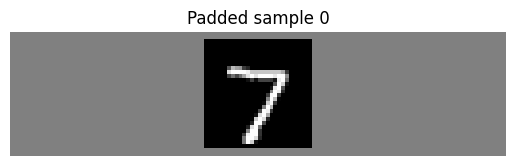

In [20]:
CROP_START_X = 50
CROP_START_Y = 2
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 128
PAD_VAL = 128
# TAKE NOTE OF THESE ^^^

# Pad the images to 128x32 with specified values and positions
test_images_subset_padded = pad_images(test_images_subset, pad_value=PAD_VAL, start_x=CROP_START_X, start_y=CROP_START_Y, target_width=IMAGE_WIDTH, target_height=IMAGE_HEIGHT)

# Check the shape of the padded images
print("Shape of padded images:", test_images_subset_padded.shape)

plt.imshow(test_images_subset_padded[0], cmap='gray')
plt.axis('off')
plt.title('Padded sample 0')
plt.show()


Now, we will export our testbench data to space deliminated data files. One input/output should occupy every line for the testbench to interpret the data correctly. Data is saved in raw uint8 format since the frame grabber firmware will be normalizing the data.

In [21]:
# Save input data
np.savetxt('my-frame-grabber-test_TEMPLATE/05_model_design_hls/tb_data/tb_input_features.dat', test_images_subset_padded.reshape(test_images_subset_padded.shape[0],-1), delimiter=' ', fmt='%d')

In [22]:
# Save output predictions
np.savetxt('my-frame-grabber-test_TEMPLATE/05_model_design_hls/tb_data/tb_output_predictions.dat', predictions_subset.reshape(predictions_subset.shape[0],-1), delimiter=' ', fmt='%.6f')

## Merging HLS designs

Now we will begin the somewhat tedious task of merging the necessary code from the hls project generated by hls4ml (my-hls-test) into the template frame grabber reference design (my-frame-grabber-test). Most of our work will be done in 05_model_design_hls/srcs. We will start with the easy stuff.

First we can copy the model type definitions, layer parameters, weights, layer templates, and arbitrary precision types over.

In [23]:
!cp -r my-hls-test/firmware/nnet_utils/ my-hls-test/firmware/weights my-hls-test/firmware/nnet_utils my-hls-test/firmware/parameters.h my-hls-test/firmware/defines.h my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs

cp: will not create hard link ‘my-frame-grabber-test_TEMPLATE_run2/05_model_design_hls/srcs/nnet_utils’ to directory ‘my-frame-grabber-test_TEMPLATE_run2/05_model_design_hls/srcs/nnet_utils’


#### defines.h

Very few modifications to these files are required. Lets start with defines.h (in my-frame-grabber-test_TEMPLATE, NOT my-hls-test). We will be using definitions from the file CustomLogic.h so lets add ```#include "CustomLogic.h"}``` in the header


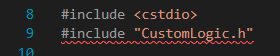

Next, we know that the frame grabber transfers 256 bits at a time (or 128 in the case of the Octo). This means in 8-bit mode, our custom logic will receive a pack of 256/8=32 pixels at a time. So we need a data type which can hold 32 model inputs. We can simply copy the input_t type defined by hls4ml, and set the array size to MONO8PIX_NBR (which is 32). We will call the type input_arr_t. After adding ```typedef nnet::array<ap_fixed<16,6>, MONO8PIX_NBR> input_arr_t;```, we are done with defines.h.

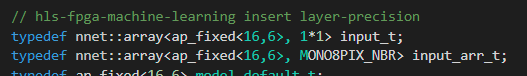

#### CustomLogic.h

Next, we will refer to CustomLogic.h. The first macro defines a divisor for normalization of your input data. By default, the firmware normalizes the input data with a division of 255 to a range of [0,1]. To change how the data is normalized, modify the ```Process_pixel``` loop of ```read_pixel_data()``` in myproject.cpp.



Next, we want to set the parameters for our camera aquisition. For this tutorial, this value and all others will be the same as those defined in the Testbench data preparation section. First enter the resolution you wish to stream at by defining the IMAGE_HEIGHT and IMAGE_WIDTH macros. Remember, IMAGE_WIDTH must be a multiple of 32. Next, specify the start x and start y positions you want to begin the crop for your ROI at. If you do not wish to crop the input to your model, simply set these two values 0. Next, specify the crop width and height. These values should be identical to the shape of your image input. In this case, the MNIST images are 28x28.


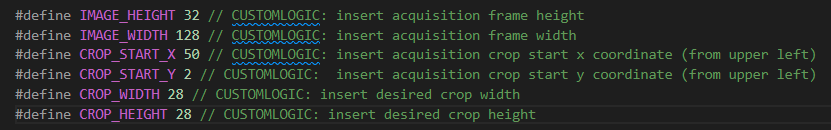

Next we will move our attention to myproject.cpp. Specifically, we will be looking at the top-level function ```myproject()```. We will notice multiple HLS streams and functions already in myproject. input_arr and VideoBuffer hold copies of the data that comes into the CustomLogic block. read_pixel_data() reads the incoming image data into the input_arr and VideoBuffer streams. These streams are sized to hold the entire incoming image. unpack_data unpacks the the image data into individual pixels which the neural network takes as input. Note that this function only unpacks data which is used to input to the model in order to save cycles and reduce streaming latency. In this case, packets of 32 pixels are unpacked and streamed into the model. 

The last function, attach_results, appends the model results to the end of the image. Note that the results are appended to the last packet of the image. As previously mentioned, the total size of the packed model results must be 256 bits or less. 

The first piece of code we want to copy over from my-hls-test's myproject.cpp to my-frame-grabber-test_TEMPLATE's myproject.cpp is the the ifndef block which loads the model weights from text files for C-simulation.
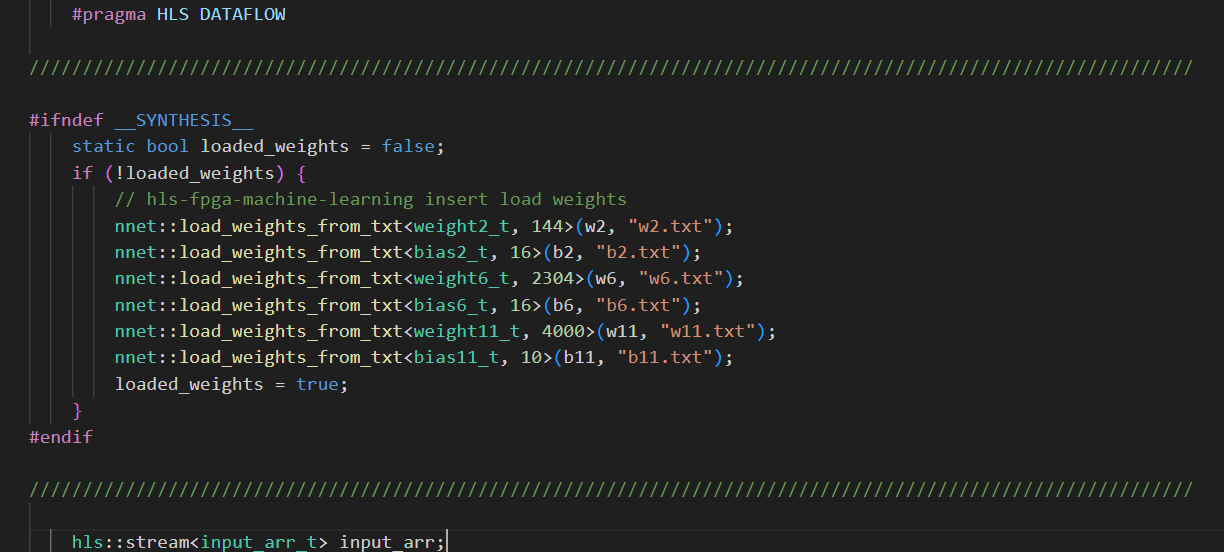

Next, we want to copy over the actual neural network layers.
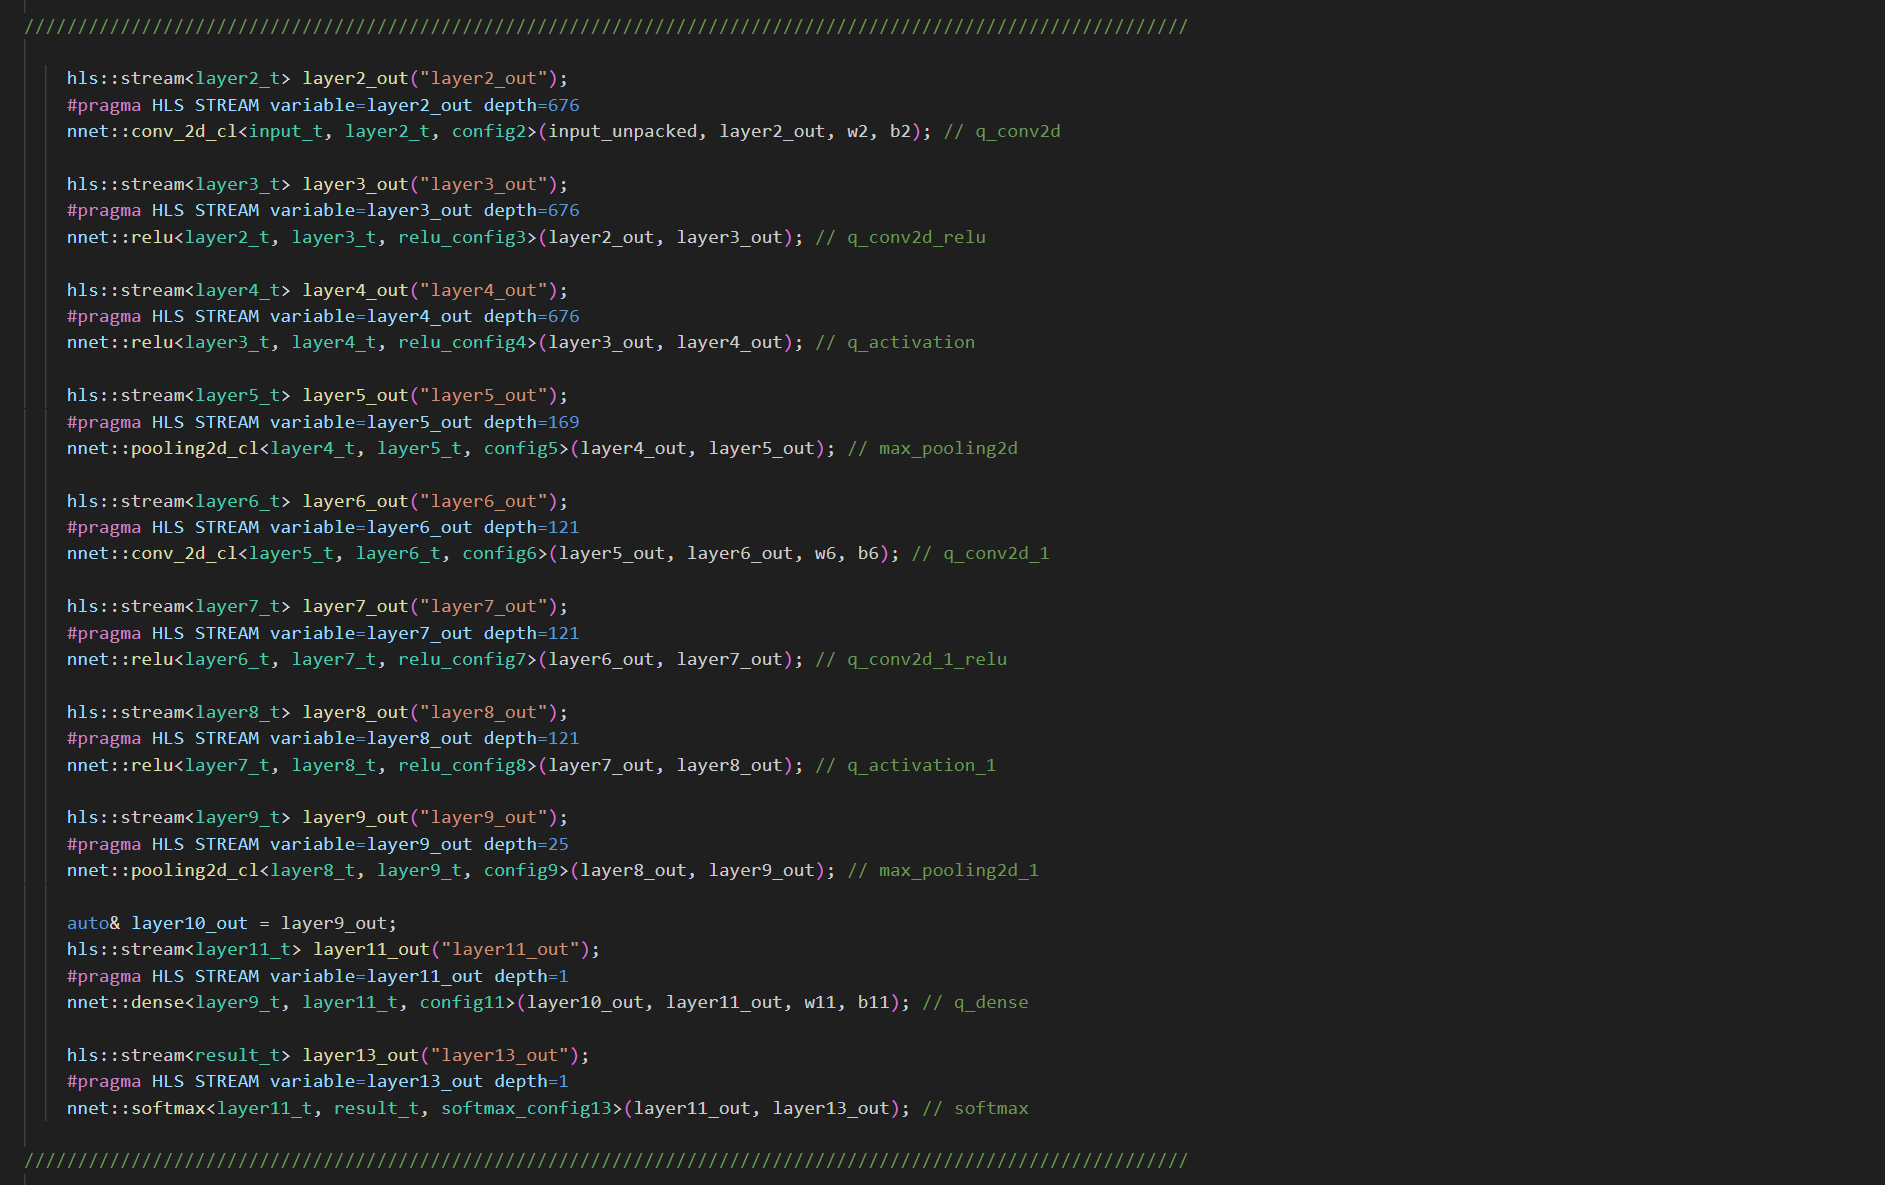

Lastly, we will need to feed the output layer of the network into the attach_results function which appends the neural network predictions to the tail-end of the image. In this case, the output stream is named "layer13_out", we will specify it as the first argument to attach_results.

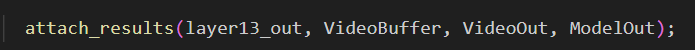

#### nnet_helpers.h

The final require modifcation to the firmware involes modifying the file nnet_utils/nnet_helpers.h. Change the value of the WEIGHTS_DIR macro to "../../../../srcs/weights".
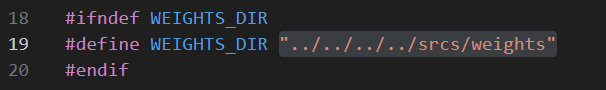

### C-simulation and C-synthesis

Now that we have added our testbench data and added our neural network to the frame grabber firmware, we can execute c simulation to validate our firmware with the predictions we produced in Python using the HLS model. Recall that the Python HLS model predictions were placed in tb_data/tb_output_predictions.dat. We can execute C-simulation by calling the tcl script named run_hls.tcl. This script also executes synthesis. Run the following command in your terminal. Note that you can prepend ```nohup``` and append ``` &``` to run c simulation and c synthesis in the background as it can take some time to complete.

```vivado_hls 05_model_design_hls/scripts/run_hls.tcl```

Once c-simulation and c-synthesis have completed, check tb_data/CNN_predictions.dat. These values should match those in tb_data/tb_output_features.dat. Futher more, you can view vivado_hls.log to see more information. The testbench outputs multiple pieces of data related to each inference. It showed the "captured image" read from the input data file, the corresponding cropped normalized model input, the model predictions, and the "received image" at the host which features the embedded model predictions in it's last data packet. The model predictions are printed again after this output, but they are sourced from the "received image", as they would be in the hardware implementation.

We can see our frame grabber CNN predictions match the HLS model's predictions from Python.
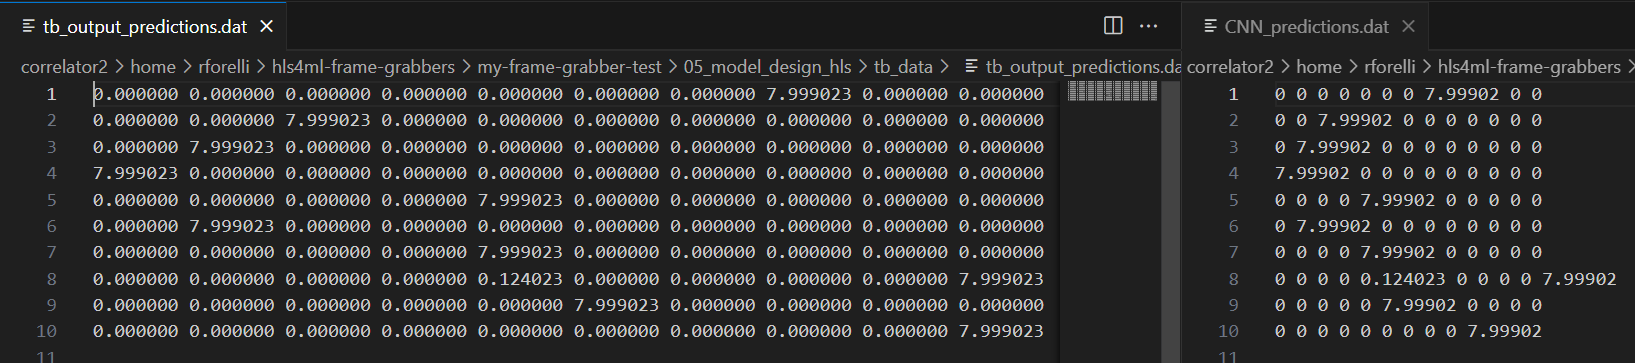

### RTL simulation and Implementation

While c-simulation is a quick and easy way to make sure our algorithm is producing the expected results, our c-simulation does not simulate the model and camera protocol at the register transfer level. To further ensure our firmware behaves in hardware as expected, we can use the RTL testbench provided by Euresys. To run the RTL simulation and begin the implementation process, run the following command. Be sure to use Vivado 2018.3.

```vivado -mode tcl -source 03_scripts/run_impl.tcl```

The testbench supplies a default input to the RTL simulation. For demonstration purposes, we will use this default input and supply the same input to our HLS model to make sure they match.

In [42]:
# Replicate default RTL testbench input
sequence = np.arange(50, 78)
array = np.tile(sequence, (28, 1)).reshape(1, 28, 28)

In [43]:
hls_model.predict(array.astype(float) / 255)

array([0.140625  , 0.25      , 0.0390625 , 0.03125   , 0.18359375,
       0.03515625, 0.09375   , 0.06640625, 0.171875  , 0.078125  ])

Supplying the same input to the c-testbench, we can see the predictions match
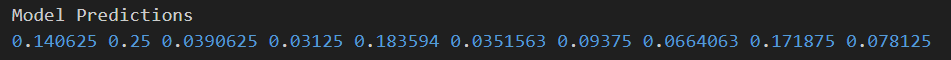

Looking at the end of the "received image" in the testbench, we can see the following sequence of numbers, representing the predictions shown above (but in a uint8 format). 
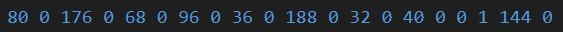

Now referring the "received image" from the RTL simulation, located in 07_vivado_project/CustomLogic.sim/sim_1/behav/xsim/cl_output_data_ch0_000.dat, we can see the same string of bytes at the tail of our image data (but represented in hexidecimal format).


### Bitstream deployment

Once your implementation completes, a bit stream should be generated and placed in /06_release named CoaxlinkQuadCxp12_1cam.bit. Use the following steps to deploy your bistream to the frame grabber FPGA.

1. Open Euresys Coaxlink Firmware Manager on host PC.
2. Drag and drop the bitstream CoaxlinkQuadCxp12_1cam.bit in upload box in Euresys Coaxlink Firmware Manager.
3. In Euresys Coaxlink Firmware Manager, navigate to the Coaxlink Cards page via the sidebar menu icon, and select your Quad CXP-12 frame grabber.
4. Select Install firmware variant....
5. Select proceed and Ok.
6. One completed, restart host PC.

### Latency Benchmarking

Next, we want to benchmark our model in hardware. First, some configuration in the eGrabber acquisition software will be required to connect the UserOutput register to TTLIO11.

1. In eGrabber Studio (or GenICam), locate the DigitalIOControl and LineSource sections
2. Assign TTLIO11 to bit 0 of the user output register (UserOutput0)
3. Under the DigitalIOControl section, select TTLIO11 in the LineSelector field
4. Set the LineMode to Output
5. Under the LineSource section, select UserOutput0

Now connect an oscilloscope or other digitizer to TTLIO11 (pin 19 of  Internal I/0 1 Connector, see [here](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/meca/connectors/inst300-int-io1.htm?tocpath=Using%20Coaxlink%7CHardware%20Manual%7CMechanical%20Specification%7CConnectors%7C_____15)).

Once you begin recording (try a low FPS to start), you should see a square wave, where the high-time denotes the model inference. We can see below, our model inference latency is X us.

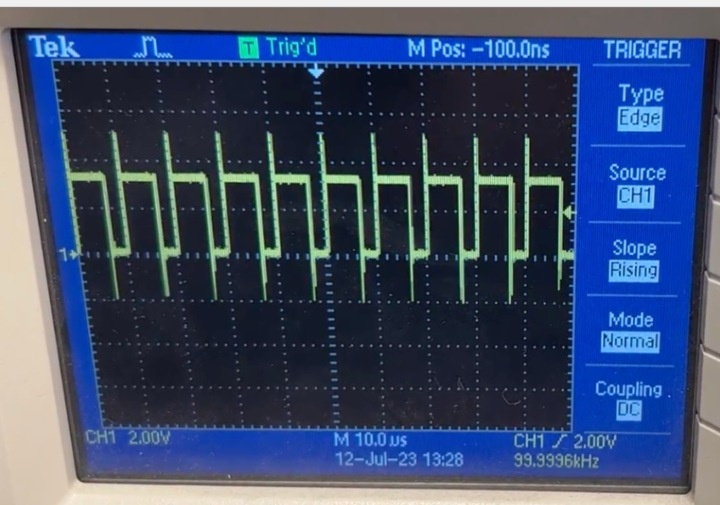

## Conclusion

Congratulations!! You have finished deploying a neural network your frame grabber's FPGA. Please feel free to reach out with feedback or questions at forelliryan@gmail.com

# TODO LIST

Short term
- Add generalized code for doing stripe reordering given only an array of sequence numbers.
- Generalize the process of switching between cameras and bit depths so only one reference design needs to be used.
- Allow user to use image widths other than multiples of 32
- Add support for packed prediction lengths >256/128 bits.

Long term
- Add support for RGB 
